# 6章 学習に関するテクニック

## 6.1 パラメータの更新

多くの研究では今でもSGDが使われている。
最近(2016年頃？)では、多くの研究者や技術者がAdamを好んで使っているらしい。

一般にSGDよりも他の改善手法の方が速く学習でき、時には最終的な認識性能も高くなる。
どの手法が良いかは、学習係数のハイパーパラメータやニューラルネットワークの構造によって変わる。

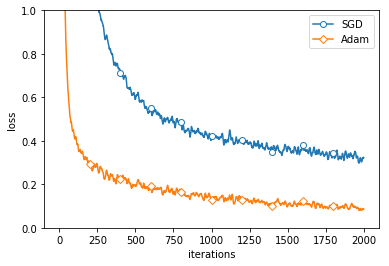

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *
from common.util import smooth_curve

def get_mini_batch(x_train, t_train, batch_size):
    train_size = x_train.shape[0]
    batch_mask = np.random.choice(train_size, batch_size)
    return x_train[batch_mask], t_train[batch_mask]


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
batch_size = 500
iters_num = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
# optimizers['Momentum'] = Momentum()
# optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
# optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[28, 28], output_size=10
                            , activation='relu', weight_init_std='he', weight_decay_lambda=0)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(iters_num):
    x_batch, t_batch = get_mini_batch(x_train, t_train, batch_size)
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "^", "AdaGrad": "s", "Adam": "D", "RMSprop": "v"}
x = np.arange(iters_num)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markerfacecolor='#ffffff', markevery=iters_num // 10, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 6.2 重みの初期値

重みの初期値が均一だと、誤差逆伝播法において、全ての重みの値が均一に更新されてしまう。
そのためランダムな初期値を重みに設定する。

重みにランダムな初期値を設定したネットワークでsigmoid関数の出力を観察する。
ヒストグラムを見ると偏りがあり、勾配消失や表現力の制限が問題になる。

Xavierの初期値を利用すると、活性化関数の出力が適度な広がりを持った分布になる。

活性化関数にsigmoid関数やtanh関数を利用するとXavierの初期値でうまくいくが、ReLUを用いる場合には偏ってしまう。
Heの初期値を利用するとReLUでも良い分布を得られるようになる。


## 6.3 Batch Normalization

適切な重みの初期値を設定すれば、各層のアクティベーションの分布が適度な広がりを持ち、学習がスムーズに行えることがわかった。

では、各層で適度な広がりを持つように**強制的に**アクティベーションの分布を調整するとどうか？そのアイデアをベースとする手法がBatch Normalizationとなる。

Batch Normの利点

- 学習を速く進行させることが出来る（学習係数を大きくすることが出来る）
- 初期値にそれほど依存しない（初期値に対してそれほど神経質にならなくて良い）
- 過学習を抑制する（Dropoutなどの必要性を減らす）

Batch NormはAffineレイヤ（X•Wするやつ）とアクティベーションレイヤの間に入れる。ミニバッチごとに正規化を行う。データの分布が平均0、分散1になるように正規化する。

m個の入力データ集合 $B = \{x_1, ..., x_m\}$
$$
\mu_B \leftarrow \frac{1}{m} \sum_{i=1}^m x_i \\
\sigma_B^2 \leftarrow \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2 \\
\hat{x}_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

$\epsilon$ はゼロ除算を防ぐために入れている。さらに固有のスケールとシフトで変換する。

$$
y_i = \gamma \hat{x}_i + \beta
$$

ここで $\gamma$ と $\beta$ はパラメータで、最初は $\gamma = 1, \beta = 0$ からスタートして、学習によって適した値に調整されていく。

逆伝播の導出はやらない。


## 6.4 正則化